# Задача 1. Реализация подсчёта треугольников

In [1]:
pip install python-graphblas[default]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 350.9/350.9 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 MB 15.7 MB/s eta 0:00:00


In [2]:
import graphblas as gb

gb.init("suitesparse", blocking=False)

from graphblas import Matrix, dtypes, unary, binary, monoid, semiring, Recorder
from graphblas.io import mmread
from scipy.sparse import coo_matrix
import numpy as np

In [3]:
M = mmread('karate.mtx')
M

"M_0"      nvals  nrows  ncols  dtype     format
gb.Matrix    156     34     34   FP64  csr (iso)
------------------------------------------------
     0    1    2    3    4    5    6    7    8    9   ...   24   25   26   27  \
0        1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0       ...                       
1   1.0       1.0  1.0                 1.0            ...                       
2   1.0  1.0       1.0                 1.0  1.0  1.0  ...                 1.0   
3   1.0  1.0  1.0                      1.0            ...                       
4   1.0                           1.0                 ...                       
5   1.0                           1.0                 ...                       
6   1.0                 1.0  1.0                      ...                       
7   1.0  1.0  1.0  1.0                                ...                       
8   1.0       1.0                                     ...                       
9             1.0                                     ...                       
10  1.0                 1.0  1.0                      ...                       
11  1.0                                               ...                       
12  1.0            1.0                                ...                       
13  1.0  1.0  1.0  1.0                                ...                       
14                                                    ...                       
15                                                    ...                       
16                           1.0  1.0                 ...                       
17  1.0  1.0                                          ...                       
18                                                    ...                       
19  1.0  1.0                                          ...                       
20                                                    ...                       
21  1.0  1.0                                          ...                       
22                                                    ...                       
23                                                    ...       1.0       1.0   
24                                                    ...       1.0       1.0   
25                                                    ...  1.0                  
26                                                    ...                       
27            1.0                                     ...  1.0                  
28            1.0                                     ...                       
29                                                    ...            1.0        
30       1.0                                1.0       ...                       
31  1.0                                               ...  1.0  1.0             
32            1.0                           1.0       ...                       
33                                          1.0  1.0  ...            1.0  1.0   

     28   29   30   31   32   33  
0                  1.0            
1             1.0                 
2   1.0                 1.0       
3                                 
4                                 
5                                 
6                                 
7                                 
8             1.0       1.0  1.0  
9                            1.0  
10                                
11                                
12                                
13                           1.0  
14                      1.0  1.0  
15                      1.0  1.0  
16                                
17                                
18                      1.0  1.0  
19                           1.0  
20                      1.0  1.0  
21                                
22                      1.0  1.0  
23       1.0            1.0  1.0  
24                 1.0            
25                 1.0            
26       1.0                 1.0  
27                           1.0  
28

In [4]:
M.dtype

FP64

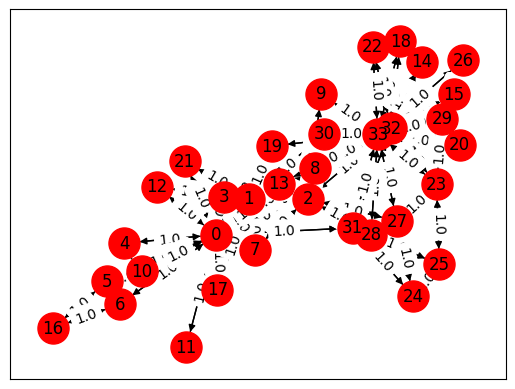

In [5]:
gb.viz.draw(M)

### Задание
####  Используя python-graphblas, реализовать алгоритм, вычисляющий и возвращающий количество треугольников неориентированного графа. <br>
#### 1. Функция принимает представление неориентированного графа, удобное для неё (загрузка, конвертация и проверка неориентированности реализованы отдельно).<br>
#### 2. Функция возвращает число - количество треугольников в графе.

### 1. Наивный алгоритм для матрицы смежности $A$, вычисляющий $A^3$

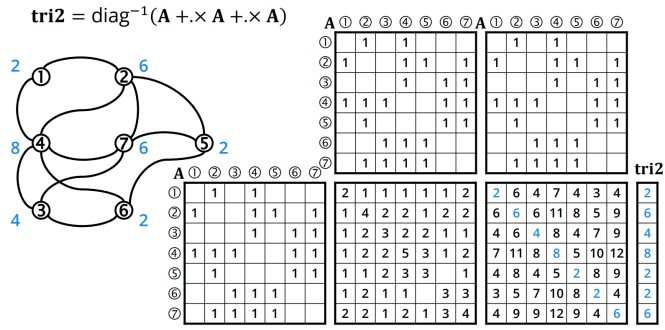

In [6]:
def naiveA3(A):

    A2 = A.mxm(A) # Умножаем A на A - получаем A^2
    A3 = A2.mxm(A) # Получаем A^3

    # Выделяем диагональ матрицы - пути длины 3 с началом и концом в одной точке, то есть треугольники
    diagonal = A3.diag()

    # Суммирование элементов на диагонали матрицы
    # value возвращает значение суммы reduce, а 0 для случая, если треугольников нет
    sum = int(diagonal.reduce(gb.agg.sum).value or 0)

    # Найдем количество треугольников
    # Деление на 6 с учетом ненаправленности графа (посчитали в 2 стороны) и пересчета треугольника по 3 раза для каждой из вершин
    num = sum / 6

    return num

### 2. Наивный алгоритм с маской для матрицы смежности $A$, вычисляющий $A^2$

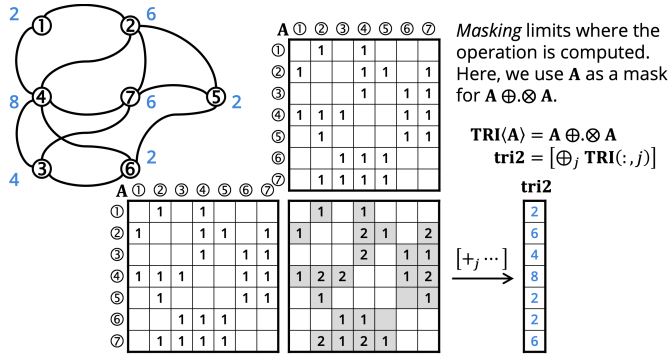

In [7]:
def naiveMaskA2(A):

    A2 = A.mxm(A) # Найдем матрицу A^2

    # Найдем маску на основе матрицы смежности A (оставляем ячейки со значениями True на месте ребер графа)
    mask = A.dup(dtype=dtypes.BOOL)

    # Применим маску к матрице A^2, оставив все пути длины 2 между вершинами с еще одним возможным путем длины 1 между ними самими
    A2mask = A2.dup(mask=mask)

    # Просуммируем все элементы матрицы в одно число или вернем 0
    sum = int(A2mask.reduce_scalar(gb.monoid.plus).value or 0)

    # Аналогичное деление на 6
    num = sum / 6

    return num

### 3. Сohen's algorithm

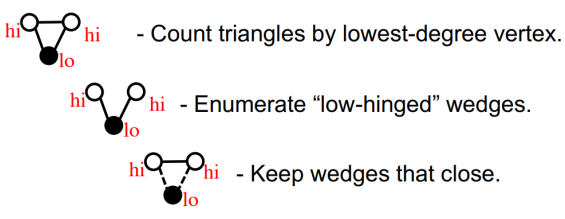

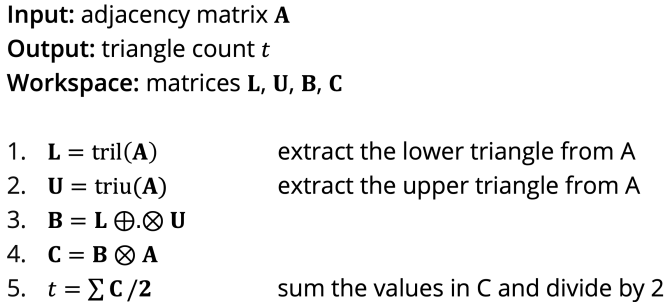

In [8]:
def cohen(A):
    # Найдем нижнетреугольную матрицу от матрицы A - все пути hi->lo
    L = gb.select.tril(A)

    # Найдем верхнетреугольную матрицу от матрицы A - все пути lo->hi
    U = gb.select.triu(A)

    B = L.mxm(U) # Умножим L на U - найдем все пути hi->lo->hi

    # Применим маску на основе матрицы смежности A, чтобы закрыть путь hi->lo->hi путем hi->hi
    mask = A.dup(dtype=dtypes.BOOL)
    C = B.dup(mask=mask)

    # Просуммируем все элементы матрицы в одно число или вернем 0
    sum = int(C.reduce_scalar(gb.monoid.plus).value or 0)

    # Деление на 2 с учетом ненаправленности графа - посчитали в 2 стороны (а вот треугольники уже считаются один раз, идентифицируясь по lo)
    num = sum / 2

    return num

### 4. Sandia algorithm

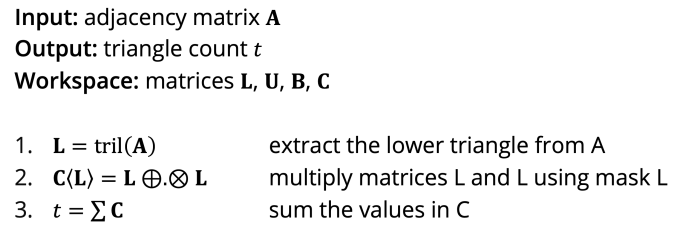

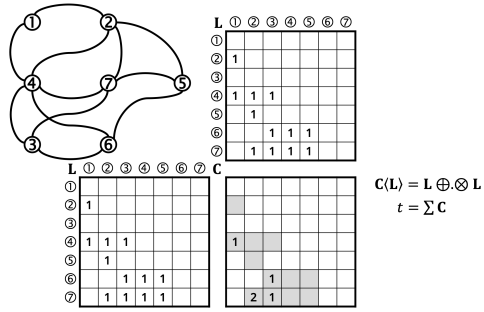

In [9]:
def sandia(A):

    # Найдем нижнетреугольную матрицу от матрицы A - все пути hi->lo
    L = gb.select.tril(A)

    mask = L.dup(dtype=dtypes.BOOL) # Создадим маску на основе матрицы L

    С = L.mxm(L).dup(mask=mask) # находим L^2 с учетом маски

    # Просуммируем все элементы матрицы в одно число или вернем 0
    num = int(С.reduce_scalar(gb.monoid.plus).value or 0)

    return num

### Тесты

In [10]:
def test(A):
    result = [naiveA3(A), naiveMaskA2(A), cohen(A), sandia(A)]
    print(result)
    if not all(result[0] == element for element in result):
       print("All return values are not equal")
    else:
        print('NaiveA3:')
        %timeit naiveA3(A)
        print('NaiveA2:')
        %timeit naiveMaskA2(A)
        print("Сohen's algorithm:", )
        %timeit cohen(A)
        print('Sandia algorithm:')
        %timeit sandia(A)

In [11]:
test(M)

[45.0, 45.0, 45.0, 45]
NaiveA3:
404 µs ± 110 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
NaiveA2:
327 µs ± 48.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
Сohen's algorithm:
658 µs ± 111 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
Sandia algorithm:
The slowest run took 4.93 times longer than the fastest. This could mean that an intermediate result is being cached.
644 µs ± 241 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


### 5. (+2 балла) Количество треугольников для каждой вершины


Используя python-graphblas реализовать функцию, вычисляющую для каждой вершины неориентированного графа количество треугольников, в которых она участвует.
1. Функция принимает представление неориентированного графа, удобное для неё (загрузка, конвертация и проверка неориентированности реализованы отдельно).<br>
2. Функция возвращает число - количество треугольников в графе.

In [12]:
def count_triangles(A):

    A2 = A.mxm(A) # Найдем матрицу A^2

    # Найдем маску на основе матрицы смежности A (оставляем ячейки со значениями True на месте ребер графа)
    mask = A.dup(dtype=dtypes.BOOL)

    # Применим маску к матрице A^2, оставив все пути длины 2 между вершинами с еще одним возможным путем длины 1 между ними самими
    A2mask = A2.dup(mask=mask)

    # Просуммируем построчно элементы матрицы в одно число
    sum = A2mask.reduce_columnwise(gb.monoid.plus)

    # Деление на 2 с учетом ненаправленности графа - посчитали в 2 стороны
    num = sum / 2

    # Найдем индексы вершин, у которых нет треугольников, и запишем в них 0
    indexes = set(range(A.shape[0])) - set(num)
    for i in indexes:
        num[i] << 0.0
    result = num.to_dict()

    return result

In [13]:
count_triangles(M)

{0: 18.0,
 1: 12.0,
 2: 11.0,
 3: 10.0,
 4: 2.0,
 5: 3.0,
 6: 3.0,
 7: 6.0,
 8: 5.0,
 9: 0.0,
 10: 2.0,
 11: 0.0,
 12: 1.0,
 13: 6.0,
 14: 1.0,
 15: 1.0,
 16: 1.0,
 17: 1.0,
 18: 1.0,
 19: 1.0,
 20: 1.0,
 21: 1.0,
 22: 1.0,
 23: 4.0,
 24: 1.0,
 25: 1.0,
 26: 1.0,
 27: 1.0,
 28: 1.0,
 29: 4.0,
 30: 3.0,
 31: 3.0,
 32: 13.0,
 33: 15.0}

### 6. (+1 балл) Тесты на больших графах
Скачать 10 графов в формате `Matrix Market` с сайта [SuiteSparse Matrix Collection](https://sparse.tamu.edu/) и оценить время работы всех полученных реализаций. Сделать выводы. <br>
<br>
В качестве фильтров для поиска графов на сайте использовать следующие значения: `Rutherford-Boeing Type` = `Binary`, `Special Structure` = `Symmetric`, `Nonzeros.Min` = 10000.

In [18]:
from timeit import default_timer as timer

def test2(A): # более удобный тест, возвращающий количество треугольников и время выполнения всех алгоритмов
    results = [naiveA3(A), naiveMaskA2(A), cohen(A), sandia(A)]
    num = results[3]
    if not all(results[0] == element for element in results):
       print("All return values are not equal")
    else:
        t1 = timer()
        naiveA3(A)
        t2 = timer()
        naive_algorithm = f'{(t2-t1):.5f}'

        t1 = timer()
        naiveMaskA2(A)
        t2 = timer()
        mask_algorithm = f'{(t2-t1):.5f}'

        t1 = timer()
        cohen(A)
        t2 = timer()
        cohen_algorithm = f'{(t2-t1):.5f}'

        t1 = timer()
        sandia(A)
        t2 = timer()
        sandia_algorithm = f'{(t2-t1):.5f}'


        return num, naive_algorithm, mask_algorithm, cohen_algorithm, sandia_algorithm

In [19]:
import pandas as pd

Ms, numbers, naive_algorithm, mask_algorithm, cohen_algorithm, sandia_algorithm  = [], [], [], [], [], []

for i in range(1, 11): # в цикле для каждой матрицы добавляем в массивы выходные значения теста
    M_i = mmread('G' + str(i) + '.mtx')
    out = test2(M_i)
    numbers.append(out[0])
    naive_algorithm.append(out[1])
    mask_algorithm.append(out[2])
    cohen_algorithm.append(out[3])
    sandia_algorithm.append(out[4])

# Скомпануем словарь для создания сравнительной таблицы
data = {'Num of triangles': numbers, 'Naive time': naive_algorithm,
        'Mask time': mask_algorithm, 'Cohen time': cohen_algorithm, 'Sandia time': sandia_algorithm}
pd.DataFrame.from_dict(data)

,Num of triangles,Naive time,Mask time,Cohen time,Sandia time
0,18093,0.19350,0.02077,0.01729,0.00204
1,18194,0.08823,0.01328,0.00960,0.00193
2,18413,0.12509,0.01306,0.01196,0.01266
3,1395,0.71318,0.04154,0.00207,0.00133
4,1338,0.16115,0.00370,0.00206,0.00130
5,1285,0.16399,0.00375,0.00209,0.00129
6,1327,0.18707,0.01205,0.00374,0.00137
7,1413,0.46227,0.05801,0.04583,0.01644
8,12783,0.21447,0.00359,0.00968,0.00159
9,12679,0.33918,0.03580,0.05106,0.00214


### Выводы <br>
Как и предполагалось, рейтинг по времени работы алгоритмов от худшего к лучшему следующий:<br>
Наивный -> С маской -> Cohen's -> Sandia.<br>
При этом, алгоритм с маской оказался лучше алгоритма Коэна только в 2 из 10 случаях.

### 7. (+2 балла) Генератор случайных неориентированных графов

Реализовать генератор случайных неориентированных графов, в котором можно задавать количество вершин и степень разреженности графа. Путём генерации случайных графов различного размера и с разной степенью разреженности, оценить время работы всех полученных реализаций и исследовать границы их применимости. Сделать выводы.

In [23]:
def generate_graph(n, density): # n - количество вершин, density - степень разреженности
    # Инициализируем пустую матрицу смежности
    matrix = np.zeros((n, n))

    # Проходим по верхнему треугольнику матрицы
    for i in range(1, n+1):
        for j in range(i, n+1):
            # Случайным образом определяем, есть ли ребро между узлами i и j
            if np.random.rand() < density:
                matrix[i-1, j-1] = 1

    # Гарантируем отсутствие петель
    np.fill_diagonal(matrix, 0)

    # Отражаем верхний треугольник в нижний, чтобы матрица стала симметричной
    for i in range(1, n+1):
        for j in range(i, n+1):
            if matrix[i-1, j-1] == 1:
                matrix[j-1, i-1] = 1

    # Преобразуем матрицу смежности в формат COO - способ представления разреженных матриц
    # В этом формате каждый ненулевой элемент матрицы представлен с указанием его координаты (строка, столбец) и значения
    matrix_coo = coo_matrix(matrix)
    rows = matrix_coo.row
    cols = matrix_coo.col

    # Создаем матрицу GraphBLAS из формата COO
    matrix = gb.Matrix.from_coo(
        rows,
        cols,
        np.ones(len(cols)),
        nrows=len(matrix_coo.diagonal()),
        ncols=len(matrix_coo.diagonal())
    )
    return matrix

In [38]:
graph = generate_graph(10, 0.3)
graph

"M_97015"  nvals  nrows  ncols  dtype         format
gb.Matrix     42     10     10   FP64  bitmapr (iso)
----------------------------------------------------
     0    1    2    3    4    5    6    7    8    9
0            1.0       1.0                         
1            1.0  1.0  1.0  1.0  1.0            1.0
2  1.0  1.0                      1.0  1.0          
3       1.0            1.0  1.0       1.0          
4  1.0  1.0       1.0       1.0            1.0  1.0
5       1.0       1.0  1.0       1.0  1.0  1.0     
6       1.0  1.0            1.0       1.0          
7            1.0  1.0       1.0  1.0            1.0
8                      1.0  1.0                    
9       1.0            1.0            1.0

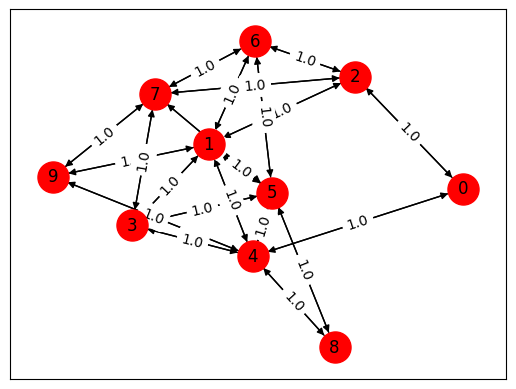

In [39]:
gb.viz.draw(graph)

In [46]:
import numpy as np

num_of_nodes, density = [], []
Ms, numbers, naive_algorithm, mask_algorithm, cohen_algorithm, sandia_algorithm  = [], [], [], [], [], []

for i in range(1000, 4000, 1000): # пройдем по сетке различных значений количества врешин и разреженности
  for j in np.arange(0.05, 0.4, 0.1):
    M_i_j = generate_graph(i, j)
    out = test2(M_i_j)
    num_of_nodes.append(i)
    density.append(j)
    numbers.append(out[0])
    naive_algorithm.append(out[1])
    mask_algorithm.append(out[2])
    cohen_algorithm.append(out[3])
    sandia_algorithm.append(out[4])

# Скомпануем словарь для создания сравнительной таблицы
data = {'Num of nodes': num_of_nodes, 'Density': density,
        'Num of triangles': numbers, 'Naive time': naive_algorithm,
        'Mask time': mask_algorithm, 'Cohen time': cohen_algorithm, 'Sandia time': sandia_algorithm}
pd.DataFrame.from_dict(data)

,Num of nodes,Density,Num of triangles,Naive time,Mask time,Cohen time,Sandia time
0,1000,0.05,20796,0.07895,0.00981,0.00411,0.00242
1,1000,0.15,560287,0.23037,0.08149,0.04414,0.01575
2,1000,0.25,2587001,0.37891,0.26553,0.09201,0.04756
3,1000,0.35,7115863,0.84463,1.08368,0.31832,0.17024
4,2000,0.05,166782,0.58497,0.07229,0.02708,0.01416
5,2000,0.15,4481004,1.78185,0.65207,0.23947,0.11285
6,2000,0.25,20836799,3.03060,2.19216,0.73459,0.38298
7,2000,0.35,56737344,4.76473,4.70483,1.74979,1.39537
8,3000,0.05,558940,1.87914,0.26275,0.08722,0.04442
9,3000,0.15,15217408,7.14609,2.23203,0.76073,0.38484


### Выводы
Согласно таблице, рейтинг алгоритмов по времени работы остался прежним. Алгоритм Sandia наиболее предпочтителен в решении задачи поиска треугольников.